In [ ]:
import ee
import pandas as pd
ee.Authenticate()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [ ]:
geometry = ee.Geometry.Polygon(
    [[[-48.624656947326656, -26.181710245683796],
    [-48.59530285186767, -26.22298800628459],
    [-48.57281521148681, -26.213901994461565],
    [-48.605087550354, -26.176472469036128]
    ]])
visRGB = {"min":0, "max":3000, "bands":["B4","B3", "B2"]}
visDepth = {"bands":["depth"], "min":0, "max":20,"palette":["00FFFF","0000FF"]}
 
def mask(img, lSCL):
  cloudBitMask = ee.Number(2).pow(10).int();
  cirrusBitMask = ee.Number(2).pow(11).int();
  qa = img.select('QA60');
  ma = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0));
  if(lSCL):
    ma = ma.And(img.select(['SCL']).neq(3));
    ma = ma.And(img.select(['SCL']).neq(4));
    ma = ma.And(img.select(['SCL']).neq(5));
    ma = ma.And(img.select(['SCL']).neq(8));
    ma = ma.And(img.select(['SCL']).neq(9));
    ma = ma.And(img.select(['SCL']).neq(10));
  
  ma = ma.And(img.select(['B9']).lt(300)); 
  ma = ma.And(img.select(['B9']).gt(50));
  ma = ma.And(img.select(['B3']).gt(100));
#    ma = ma.focal_min({'kernel': ee.Kernel.circle({'radius': 1}), 'iterations': 1});
  img = img.mask(ma);

  ndwi_revise = (img.select([2]).subtract(img.select([7]))).divide(img.select([2]).add(img.select([7])));
  img = img.updateMask(ndwi_revise.gt(0));
  
  return img
  
def addQAband(image):
  # Normalized difference vegetation index.
  ndvi = image.normalizedDifference(['B8', 'B3']).multiply(-1);
  qa = ((image.select(['B1']).multiply(ee.Number(ee.List(genes).get(0))))
  .add(image.select(['B2']).multiply(ee.Number(ee.List(genes).get(1))))
  .add(image.select(['B3']).multiply(ee.Number(ee.List(genes).get(2))))
  .add(image.select(['B4']).multiply(ee.Number(ee.List(genes).get(3))))
  .add(image.select(['B5']).multiply(ee.Number(ee.List(genes).get(4))))
  .add(image.select(['B6']).multiply(ee.Number(ee.List(genes).get(5))))
  .add(image.select(['B8']).multiply(ee.Number(ee.List(genes).get(6))))
  .add(image.normalizedDifference(['B8', 'B3']).multiply(ee.Number(ee.List(genes).get(7))))).multiply(-0.1).rename('QA');
  # Image timestamp as milliseconds since Unix epoch.
  return image.addBands([ndvi, qa]);

sentinel = ee.ImageCollection('COPERNICUS/S2_SR')\
  .filterBounds(geometry).filterDate('2018-05-01', '2018-06-30');
#print(sentinel)
#sentinel = sentinel.filter(ee.Filter.date(ee.Date.fromYMD(2018,5,20),ee.Date.fromYMD(2018,5,21)));

if sentinel.size().eq(0):
  sentinel = ee.ImageCollection('COPERNICUS/S2')\
    .filterBounds(geometry).filterDate('2018-05-01', '2018-06-30');
  #sentinel = sentinel.filter(ee.Filter.date(ee.Date.fromYMD(2018,5,20),ee.Date.fromYMD(2018,5,21)));

sentinel = sentinel.map(addMask);
sentinel = sentinel.map(addQAband);

In [ ]:
import ee
import folium
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Mask out land and clouds
from random import randint
from time import sleep, time
from multiprocessing.pool import ThreadPool

	
def startBatimetria(genes) :
  table = ee.FeatureCollection("projects/ee-jfelipecarvalho1/assets/batimetria_babitonga_2018_50K")
  geometry = ee.Geometry.Point(
     [-48.624656947326656, -26.181710245683796])
  visRGB = {"min":0, "max":3000, "bands":["B4","B3", "B2"]}
  visDepth = {"bands":["depth"], "min":0, "max":20,"palette":["00FFFF","0000FF"]}

  def mask(img, lSCL):
    cloudBitMask = ee.Number(2).pow(10).int();
    cirrusBitMask = ee.Number(2).pow(11).int();
    qa = img.select('QA60');
    ma = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0));
    if(lSCL):
      ma = ma.And(img.select(['SCL']).neq(3));
      ma = ma.And(img.select(['SCL']).neq(4));
      ma = ma.And(img.select(['SCL']).neq(5));
      ma = ma.And(img.select(['SCL']).neq(8));
      ma = ma.And(img.select(['SCL']).neq(9));
      ma = ma.And(img.select(['SCL']).neq(10));
    
    ma = ma.And(img.select(['B9']).lt(300)); 
    ma = ma.And(img.select(['B9']).gt(50));
    ma = ma.And(img.select(['B3']).gt(100));
#    ma = ma.focal_min({'kernel': ee.Kernel.circle({'radius': 1}), 'iterations': 1});
    img = img.mask(ma);

    ndwi_revise = (img.select([2]).subtract(img.select([7]))).divide(img.select([2]).add(img.select([7])));
    img = img.updateMask(ndwi_revise.gt(0));
    
    return img
    
  def addQAband(image):
    # Normalized difference vegetation index.
    ndvi = image.normalizedDifference(['B8', 'B3']).multiply(-1);
    qa = ((image.select(['B1']).multiply(ee.Number(ee.List(genes).get(0))))
    .add(image.select(['B2']).multiply(ee.Number(ee.List(genes).get(1))))
    .add(image.select(['B3']).multiply(ee.Number(ee.List(genes).get(2))))
    .add(image.select(['B4']).multiply(ee.Number(ee.List(genes).get(3))))
    .add(image.select(['B5']).multiply(ee.Number(ee.List(genes).get(4))))
    .add(image.select(['B6']).multiply(ee.Number(ee.List(genes).get(5))))
    .add(image.select(['B8']).multiply(ee.Number(ee.List(genes).get(6))))
    .add(image.normalizedDifference(['B8', 'B3']).multiply(ee.Number(ee.List(genes).get(7))))).multiply(-0.1).rename('QA');
    # Image timestamp as milliseconds since Unix epoch.
    return image.addBands([ndvi, qa]);
    # Create a FeatureCollection containing each points' band information and depth
  def createPoints(el):
      return ee.Feature(ee.Geometry.Point([el.get('X'),el.get('Y')], 'EPSG:32722'),
      {'depth': el.get('Z')})
    
    
    # Calculate the NDWI value (Green and Blue bands) and the Reason (Green and Blue bands)
  def calculateReason(el):
      return ee.Feature(el.geometry()).set('depth', el.get('depth')).set('ndwi', ee.Feature(ee.Number(\
        el.get('B3')).subtract(el.get('B2')).divide(ee.Number(el.get('B3')).add(el.get('B2'))))).set('ratio', ee.Feature(\
        ee.Number(el.get('B3')).multiply(1).log().divide(ee.Number(el.get('B2')).multiply(1).log()))).set('constant', 1)

    # Create raster with the predicted depth
  def createPredictionRaster(el):
    ndwi = el.select('B3').subtract(el.select('B2')).divide(el.select('B3').add(el.select('B2'))).rename('NDWI');
    el = el.addBands(ndwi);
    depth = el.select('NDWI').multiply(ee.Number(slope)).add(ee.Number(yInt)).rename('depth');
    return el.addBands(depth);

  def addMask(image):
    return mask(image.clip(geometry),False);

  def fPredict(image):  
    return ee.Feature(image.geometry()).set('depth', image.get('depth')).set('predicted_depth', ee.Number(\
        image.get('ndwi')).multiply(slope).add(yInt)).set('diff', ee.Number(image.get('depth')).subtract(ee.Number(image.get('ndwi')).multiply(slope).add(yInt)).abs().pow(2))
      
  # QA60 band cloud bits

  runtime = []
  threads = []

  pool = ThreadPool(processes=4)


  points = table.map(createPoints);
  sentinel = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterBounds(geometry).filterDate('2018-05-01', '2018-06-30');

  sentinel = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterBounds(geometry).filterDate('2018-05-01', '2018-06-30');
  #print(sentinel)
  #sentinel = sentinel.filter(ee.Filter.date(ee.Date.fromYMD(2018,5,20),ee.Date.fromYMD(2018,5,21)));

  if sentinel.size().eq(0):
    sentinel = ee.ImageCollection('COPERNICUS/S2')\
      .filterBounds(geometry).filterDate('2018-05-01', '2018-06-30');
    #sentinel = sentinel.filter(ee.Filter.date(ee.Date.fromYMD(2018,5,20),ee.Date.fromYMD(2018,5,21)));

  pool = ThreadPool(processes=4)
  start = time()
  
  sentinel = sentinel.map(addMask);
  sentinel = sentinel.map(addQAband);
  end = time()
  
 

  temp = sentinel.toList(999);
  image = ee.Image(temp.get(1))
  


  im = image
  image = sentinel.qualityMosaic('QA');

  band_arr_b2 = im.get('B2')
  print("band_arr_b2",band_arr_b2.getInfo())
  np_arr_b4 = np.array(band_arr_b2.getInfo())
  print(np_arr_b4)

  # Associate each point with the band values retrived from the Sentinel image
  pointFilter = points.filterBounds(geometry);
  pointData =  image.reduceRegions(
              reducer=ee.Reducer.median(),
              collection=pointFilter,
              scale=10,
              crs=ee.Projection('EPSG:32722')
              )


  pointData = pointData.filter(ee.Filter.lte('depth', 17))
  trainingData = pointData.map(calculateReason, True)



  # Apply a Linear Regression model to the data
  linearRegression = ee.Dictionary(trainingData.reduceColumns(
    reducer= ee.Reducer.linearRegression(
      numX= 2,
      numY= 1
    ),
    selectors= ['constant', 'ndwi', 'depth']
  ));


  coefList = ee.Array(linearRegression.get('coefficients')).toList();



  yInt = ee.List(coefList.get(0)).get(0); # y-intercept
  slope = ee.List(coefList.get(1)).get(0); # slope
  start = time()
  predictedData = trainingData.map(fPredict)


  rmse = ee.Number(
    predictedData
    .reduceColumns(ee.Reducer.sum(), ['diff'])
    .get('sum')
  ).divide(predictedData.size()).sqrt()


  return rmse;

'''pool = ThreadPool(processes=4)
start = time()
threads = []
for i in range(10):
  async_result = pool.apply_async(startBatimetria, ([0.05, 0.002, 0.01, 0.0006, 0.004, 0.3, 0.07, 0.0008],i,))
  threads.append(async_result)

letters_list = [result.get() for result in threads]
end = time()

print(letters_list)
print('tempo de execução final: {}'.format(end - start))'''
startBatimetria([0.05, 0.002, 0.01, 0.0006, 0.004, 0.3, 0.07, 0.0008])

band_arr_b2 None
None


In [ ]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 12.5 MB/s 


In [ ]:
# INSERT YOUR PROJECT HERE
PROJECT = 'fabled-opus-361912'
!gcloud auth login --project {PROJECT}

In [ ]:
# INSERT YOUR SERVICE ACCOUNT HERE
SERVICE_ACCOUNT=''
KEY = ''

!gcloud iam service-accounts keys create {KEY} --iam-account {SERVICE_ACCOUNT}

In [ ]:
from google.auth.transport.requests import AuthorizedSession
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(KEY)
scoped_credentials = credentials.with_scopes(
    ['https://www.googleapis.com/auth/cloud-platform'])

session = AuthorizedSession(scoped_credentials)

url = 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/LANDSAT'

response = session.get(url)

from pprint import pprint
import json
pprint(json.loads(response.content))


{'id': 'LANDSAT',
 'name': 'projects/earthengine-public/assets/LANDSAT',
 'type': 'FOLDER'}


Get de imagens disponíveis

In [ ]:

def getImages():
  geometry = [[-48.624656,-26.176472],
      [-48.572815,-26.176472],
      [-48.572815,-26.222988],
      [-48.624656,-26.222988],
      [-48.624656,-26.176472],]    

  project = 'projects/earthengine-public'
  asset_id = 'COPERNICUS/S2'
  name = '{}/assets/{}'.format(project, asset_id)
  url = 'https://earthengine.googleapis.com/v1alpha/{}:listImages?{}'.format(
    name, urllib.parse.urlencode({
      'startTime': '2018-05-20T00:00:00.000Z',
      'endTime': '2018-05-21T00:00:00.000Z',
      'region': '{"type":"Point", "coordinates":' + str(geometry[0]) + '}',
      'filter': 'CLOUDY_PIXEL_PERCENTAGE < 10',
  }))

  response = session.get(url)
  content = response.content
  aImages = []
  for asset in json.loads(content)['images']:
      id = asset['id']
      cloud_cover = asset['properties']['CLOUDY_PIXEL_PERCENTAGE']
      print('%s : %s' % (id, cloud_cover))
      asset_id = id
      
      aImages.append(requestImage(asset_id,geometry,defineAsset(asset_id, geometry )))

  return aImages   

preparando o Asset

In [ ]:

def defineAsset(asset_id, geometry ):
  project = 'projects/earthengine-public'
  name = '{}/assets/{}'.format(project, asset_id)
  url = 'https://earthengine.googleapis.com/v1alpha/{}'.format(name,urllib.parse.urlencode({
      'startTime': '2018-05-20T00:00:00.000Z',
      'endTime': '2018-05-21T00:00:00.000Z',
      'region': '{"type": "Polygon", "coordinates":' + str(geometry) + '}',
      'filter': 'CLOUDY_PIXEL_PERCENTAGE < 10',
      'grid': {
          'crsCode': 'EPSG:4326',
          'dimensions': {'width': 256, 'height': 256},
          'affineTransform': {
              'scaleX': 10,
              'scaleY': -10,
              'translateX': geometry[0][0],
              'translateY': geometry[0][1]

            },
      },
  }))

  response = session.get(url)
  content = response.content

  asset = json.loads(content)
  return asset

Fazendo request da imagem especifica

In [ ]:


def requestImage(asset_id, geometry, asset ):
  #(-48.624656 - -48.572815 ) / 1024 = -0,000050
  #(-26.222988 - -26.176472) / 1024 =  -0,000045
  project = 'projects/earthengine-public'
  name = '{}/assets/{}'.format(project, asset_id)
  url = 'https://earthengine.googleapis.com/v1alpha/{}:getPixels'.format(name, urllib.parse.urlencode({
      'startTime': '2018-05-20T00:00:00.000Z',
      'endTime': '2018-05-21T00:00:00.000Z',
      'region': '{"type": "Polygon", "coordinates":' + str(geometry) + '}',
  }))
  coord = asset['geometry']['coordinates']
  coord[0]=geometry
  body = json.dumps({
      'fileFormat': 'NPY',
      'bandIds': ['B2', 'B3', 'B4','B5','B6','B8'],
      'region': asset['geometry'],
      'grid': {
          'crsCode': 'EPSG:4326',
          'dimensions': {'width': 1024, 'height': 1024},
          'affineTransform': {
              'scaleX': 14,
              'scaleY': -14,
            },
      },
  })

  pixels_response = session.post(url, body)
  pixels_content = pixels_response.content
  array = numpy.load(io.BytesIO(pixels_content))
  array2 = []
  for i in range(len(array)):
    array2.append([])
    for j in range(len(array[i])):
        alist = list(array[i,j])
        alist.append(float((alist[1] - alist[0]) / (alist[1] + alist[0])))
        array2[i].append(alist)
  #-48.60559, -26.19141
  array2 = numpy.array(array2, dtype=np.float32)
  array3 = array2.copy()
  #array2 = array2.astype(float)
  #array2 = array2/array2.max()
  #plt.imshow(array2)
  return array3



In [ ]:
import random
import math
from itertools import repeat

from random import randint
from time import sleep, time
from multiprocessing.pool import ThreadPool
import urllib
import numpy
import io
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from pyproj import CRS
from math import trunc
  
aImages = getImages()
aDataframe = pd.read_excel("dataframe.xlsx")
  

COPERNICUS/S2/20180515T132229_20180515T132329_T22JGS : 1.8081


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in ushort_scalars


COPERNICUS/S2/20180520T132241_20180520T132235_T22JGS : 0
COPERNICUS/S2/20180530T132231_20180530T132842_T22JGS : 4.6685
COPERNICUS/S2/20180714T132229_20180714T132231_T22JGS : 1.0056


AG

In [ ]:
import random
import math
from itertools import repeat

from random import randint
from time import sleep, time
from multiprocessing.pool import ThreadPool
import urllib
import numpy
import io
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from pyproj import CRS
from math import trunc

#Primeiropassodefiniçãodeiáveis
tamPopulation=100
tamGerations=100
tamGenes=8
genes = []
reproduction=65
qtdIndRep=tamPopulation*reproduction/100
mutation=35
qtdIndMut=tamPopulation*mutation/100
perMutation=0.21
CritStop=100
#batimetria=require('users/jfelipecarvalho1/batimetria:batimetria');
#Segundopassoiniciodapopulação



#print(getRandomArbitrary(1,2))
def getRandomArbitrary(min,max):
  return random.uniform(min, max);

def geraPopulacao():
  genes = []
  population=[]
  for i in range(tamPopulation):
    for j in range(tamGenes):	
      genes.append(getRandomArbitrary(0,1))
    individuo={
        "gene"		:	genes,
        "score"		:	0}
    population.append(individuo)
    genes= []
  return population

def onePointCros(aPais):
  aFilhos=[]

  point=int(getRandomArbitrary(2,6))
  if len(aPais) < 2:
    print("one point Pais",aPais)
  rightGene1=aPais[0]['gene'][0:point]
  leftGene1=aPais[0]['gene'][point:tamGenes]
  rightGene2=aPais[1]['gene'][point:tamGenes]
  leftGene2=aPais[1]['gene'][0:point]

  individuo1={
    "gene"		:	rightGene1 + leftGene1,
    "score"		:	0
  }
  individuo2={
    "gene"		:	rightGene2 + leftGene2,
    "score"		:	0
  }
  aFilhos.append(individuo1)
  aFilhos.append(individuo2)
  return aFilhos


def crosAritm(aPais):
	aFilhos=[]	
	point=getRandomArbitrary(0,1)
	genes1=[]
	genes2=[]
	
	for i in range(tamGenes):
		genes1.append((aPais[0]["gene"][i]*point) + (aPais[1]["gene"][i]*(1-point)))
		genes2.append((aPais[0]["gene"][i]*(1-point)) + (aPais[1]["gene"][i]*point) )
	
	individuo1={
			"gene"		:	genes1,
			"score"		:	0
	}
	individuo2={
			"gene"		:	genes2,
			"score"		:	0
	}
	aFilhos.append(individuo1)
	aFilhos.append(individuo2)
	return aFilhos




def gerNewPopulation(population, nSumScore):
  newPopulation = []
  aMutados = []
  qtdMut=0
  qtdRep=0
  aPais = []
  aFilhos = []
  niter=2
  newPopulation.append(population[0])
  newPopulation.append(population[1]) 
  while(len(newPopulation)<tamPopulation):		
    ran = getRandomArbitrary(0,1);
    if ran<0.5:
      aPais = selecaoRoleta(population, nSumScore)
        
    else:
      aPais = selecaoTorneio(population)

        
    ran=getRandomArbitrary(0,1)
    if ran<0.5 and qtdMut<qtdIndMut:	
      aMutados= fazerMutacao(aPais)
      newPopulation.append(aMutados[0])
      newPopulation.append(aMutados[1])
      qtdMut+=2

    else:
      aFilhos=crossover(aPais)
      for k in range(len(aFilhos)):
        newPopulation.append(aFilhos[k])
      
    qtdRep+= len(aFilhos)

    random.shuffle(newPopulation)



  
  return newPopulation




def selecaoTorneio(population):
  quebra=int(tamPopulation/2)
  ini=1
  rightSide = population[ini:quebra]
  leftSide = population[quebra:tamPopulation]
  cont=0
  pivo1=0
  pivo2=0
  element=population[0]
  
  while(len(rightSide)!=1):
    if(rightSide[cont]["score"]<rightSide[cont+1]["score"]):
      del(rightSide[cont+1])
    else:
      del(rightSide[cont])
    if(cont+1>=len(rightSide)-1):
      cont=0
    else:
      cont+= 1
    
  while(len(leftSide)!=1):
    if(leftSide[cont]["score"]<leftSide[cont+1]["score"]):
      del(leftSide[cont+1])
    else:
      del(leftSide[cont])
    
    if(cont+1>=len(rightSide)-1):
      cont=0
    else:
      cont+= 1
    
    
  return[leftSide[0],rightSide[0]]	



def selecaoRoleta(population, sumScore):
#ordernaapopulaçãopeloscore
  roleta=[0 for i in range(int(tamPopulation*sumScore))] 
  qtdPosicoes=0
  for i in range(int(tamPopulation*sumScore)):
    roleta[i]=-1
  population = sorted(population, key=lambda k: k['score'])
  sum=0;
  for i in range(tamPopulation):
    perPos=population[i]["score"]/sumScore;
    qtdPosicoes= int(len(roleta) * perPos);
    for j in range(qtdPosicoes):
      ran=int(getRandomArbitrary(0,len(roleta)-1))
      while(roleta[ran]!=-1):
        ran=int(getRandomArbitrary(0,len(roleta)-1))

      roleta[ran]=population[i]["score"]
    
  valPai1=int(getRandomArbitrary(0,len(roleta)-1))
  scorePai1=roleta[valPai1]

  valPai2=int(getRandomArbitrary(0,len(roleta)-1))
  scorePai2=roleta[valPai2]
  while(scorePai1==scorePai2):
    valPai2=int(getRandomArbitrary(0,len(roleta)-1))
    scorePai2=roleta[valPai2]
  
  aPais=[]
  
  for i in range(len(population)):
    if(math.isclose(population[i]["score"],scorePai1)):        
      aPais.append(population[i])
    elif(math.isclose(population[i]["score"],scorePai2)):       
      aPais.append(population[i])

  if len(aPais) == 0:
    aPais.append(population[0])
    aPais.append(population[1])
  elif len(aPais) == 1:
    aPais.append(population[0])
  
  return aPais


def crossover(aPais):
	aFilhos=[]
			
	ran=getRandomArbitrary(0,1)
	if(ran<0.5):
		aFilhos=onePointCros(aPais)
	
	else:
		aFilhos=crosAritm(aPais)
	
	return aFilhos


def fazerMutacao(aPais):
  gene=[]
  aMutados=[]
  indiv={}

  ran=int(getRandomArbitrary(0,tamGenes-1))
  indiv=aPais[0]


  indiv['gene'][ran]=indiv['gene'][ran] * 0.21
  aMutados.append(indiv)

  ran=int(getRandomArbitrary(0,tamGenes -1))
  if len(aPais) < 2:
    print(aPais)
  indiv=aPais[1]
  #print(indiv)
  indiv['gene'][ran]=indiv['gene'][ran] * 0.21
  aMutados.append(indiv)
  return aMutados


def iniciar(aImages, aDataframe):
  population = []
  population = geraPopulacao();  
  numGerations=1
  minimum = 100

  
  #fazoalgoritmorodarportempoindeterminado
  sumScore = 0
  #print(tamGerations)
  while(numGerations<tamGerations):
    threads = []
    #passaporcadaindivíduoeaplicanasimagensparaobterapontuaçãodecadaum
    for i in range(tamPopulation):
      score=0
      pool = ThreadPool(processes=4)
      start = time()
      score= startBatimetria(aImages,aDataframe,population[i]['gene'])
      print(score)
      minimum = min(minimum, score)

      ind=population[i]
      ind['score']=score
      population[i]=ind
      sumScore+=score


    population = gerNewPopulation(population, sumScore)
    numGerations+=1
    print("num gerations",numGerations)
    print("tam gerations",tamGerations)
    print("comparison",numGerations>= tamGerations)
    print("population",population)
    if numGerations>= tamGerations and minimum == 0:
      break


  for k in range(tamPopulation):
    print(population[k]['score'])
	

#TerceiroPasso
iniciar(aImages, aDataframe)

In [ ]:
aImages = getImages()
aGenesColab = [0.14988319316143167, 0.03642752726035439, 0.08309747169066753, 0.03677063199521642, 0.010836578806503726, 0.4516762983206234, 0.003472148373289515, 0.7451927617669726]
aGenesLocal = [1.6828065948845707e-06, 0.005877037046899888, 1.721331265285935e-05, 3.363777204590475e-06, 1.5914036977669767e-05, 9.005818542769562e-06, 0.00036691764204322216, 0.6558244340065198]
for i in range(1024):
    for j in range(1024):
      nMaior = 0
      idMaior = 0
      for k in range(len(aImages)):
        NDWI = float((aImages[k][i][j][1] - aImages[k][i][j][3]) / (aImages[k][i][j][1] + aImages[k][i][j][3]))
        nSomaBand = aImages[k][i][j][0] * aGenes[3] +  aImages[k][i][j][1] * aGenes[2] +  aImages[k][i][j][2] * aGenes[1] + aImages[k][i][j][3] * aGenes[6]  + \
        aImages[k][i][j][4] * aGenes[0] + aImages[k][i][j][5] * aGenes[4]  + aImages[k][i][j][6] * aGenes[5] + NDWI * aGenes[7]
        if nSomaBand > nMaior:
          nMaior = nSomaBand
          idMaior = k
      aImageTest[i][j] = aImages[idMaior][i][j]


In [ ]:
def startBatimetria(aImages, aDataframe, aGenes):
  aImageTest = numpy.zeros(shape=(1024,1024,7))
  #['B4', 'B3', 'B2','B8','B1','B5', 'B6'],
  for i in range(1024):
    for j in range(1024):
      nMaior = 0
      idMaior = 0
      for k in range(len(aImages)):
       # NDWI = float((aImages[k][i][j][1] - aImages[k][i][j][3]) / (aImages[k][i][j][1] + aImages[k][i][j][3]))
        nSomaBand = aImages[k][i][j][0] * aGenes[0] +  aImages[k][i][j][1] * aGenes[1] +  aImages[k][i][j][2] * aGenes[2] + aImages[k][i][j][3] * aGenes[3]  + \
        aImages[k][i][j][4] * aGenes[4] + aImages[k][i][j][5] * aGenes[5]  + aImages[k][i][j][6] * aGenes[6] + aImages[k][i][j][7] * aGenes[7]
        if nSomaBand > nMaior:
          nMaior = nSomaBand
          idMaior = k
      aImageTest[i][j] = aImages[idMaior][i][j]
    
  #print(aDataframe)
  projection_depth = formDataframeBand(aDataframe, aImageTest)
  projection_depth = projection_depth.reset_index(drop=True)

  return fMultipleRegress(projection_depth)
        

convertendo as coordenadas e filtrando de acordo com a projection

In [ ]:

def convertCoords():
  crs_32722 = CRS.from_epsg(32722)
  crs_4326 = CRS.from_epsg(4326)
  transformer = Transformer.from_crs(crs_32722, crs_4326)
  transformer = Transformer.from_crs(32722, 4326)
  transformer = Transformer.from_crs("EPSG:32722", "EPSG:4326")
  transformer


  df = pd.read_excel("batimetria_babitonga_2018_50K.xlsx")


  for index, row in df.iterrows():
    aPivo = []
    aPivo.append(list(transformer.transform(row['X'], row['Y'])))
    row['X'] = aPivo[0][0]
    row['Y'] =  aPivo[0][1]
    #aData.append(list(transformer.transform(row['X'], row['Y'])))
    #aData[index].insert(2,row['Z'])

  projection_depth = df.query("Y > -48.624656 and  Y < -48.572815 and X > -26.222988 and X <  -26.176472 and Z <= 17")
  projection_depth['B2'] = 0
  projection_depth['B3'] = 0
  projection_depth['B4'] = 0
  projection_depth['B8'] = 0
  projection_depth['B1'] = 0
  projection_depth['B5'] = 0
  projection_depth['B6'] = 0
  projection_depth['NDWI'] = 0
  return projection_depth

juntando os valores de bandas as coordenadas

In [ ]:

def formDataframeBand(projection_depth, array3):
  for ind, row in projection_depth.iterrows():
    y = trunc((26.222988 - abs(row['X']))/0.00004546)
    x = trunc((abs(row['Y'])-48.572815)/0.00005066)
    projection_depth.loc[ind,'B2'] = array3[int(x)][int(y)][0]
    projection_depth.loc[ind,'B3'] = array3[int(x)][int(y)][1]
    projection_depth.loc[ind,'B4'] = array3[int(x)][int(y)][2]
    projection_depth.loc[ind,'B8'] = array3[int(x)][int(y)][3]
    projection_depth.loc[ind,'B1'] = array3[int(x)][int(y)][4]
    projection_depth.loc[ind,'B5'] = array3[int(x)][int(y)][5]
    projection_depth.loc[ind,'B6'] = array3[int(x)][int(y)][6]
    projection_depth.loc[ind,'NDWI'] = float((array3[int(x)][int(y)][1] - array3[int(x)][int(y)][3]) / (array3[int(x)][int(y)][1] + array3[int(x)][int(y)][3]))
  projection_depth['NDWIB'] = (projection_depth['B3'] - projection_depth['B2']) / (projection_depth['B3'] + projection_depth['B2'])
    
  return projection_depth
  #1= B3  e 3 = B8
  # NDWI =  3- 8 / 3 + 8
  #row['B2'] = array3[int(x)][int(y)][2]
# X index 0 = -48.572815
# Y index 0 = -26.222988
#teste 0,05184
#teste 0,046516
#(-48.624656 - -48.572815 ) / 1024 = -0,000051 - 0,00005066
#(-26.222988 - -26.176472) / 1024 =  -0,000045 - 0,00004546

#bandas = pd.DataFrame(array3, columns = ['B4', 'B3', 'B2'])


exportando dados

In [ ]:
def prepareAndExport(projection_depth):
  print(projection_depth)
  marks_data = projection_depth.reset_index(drop=True)
  file_name = 'MarksData.xlsx'
  marks_data.to_excel(file_name, index=False)

Regressão linear múltipla


Analisando os dados

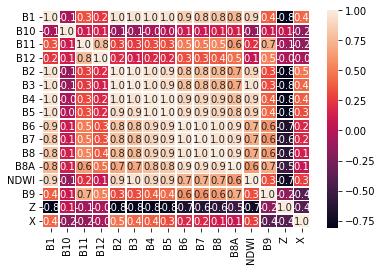

In [11]:
import pandas as pd
import seaborn as sn

data = pd.read_excel("pointData2.xlsx")


correlation = data.corr()


plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot


Separando as colunas

In [15]:
X = data.drop(columns=['B1','B10', 'B5', 'B8','B6','B7','B8','B8A','B9','X', 'Y','Z','B11','B12'])
print(X)
y = data.drop(columns=['B7', 'B8', 'B2','B3','B4', 'B8','B9','B1','B5','B6','B10', 'B11', 'B12', 'B8A', 'X', 'Y'])
print(y)

         B2   B3   B4      NDWI
0      1061  883  582 -0.091564
1      1061  883  582 -0.091564
2      1050  859  593 -0.100052
3      1050  859  593 -0.100052
4      1050  859  593 -0.100052
...     ...  ...  ...       ...
13505  1050  859  593 -0.100052
13506  1057  868  637 -0.098182
13507   983  767  438 -0.123429
13508   942  705  381 -0.143898
13509  1021  829  648 -0.103784

[13510 rows x 4 columns]
           NDWI     Z
0     -0.091564  2.00
1     -0.091564  2.00
2     -0.100052  2.00
3     -0.100052  2.00
4     -0.100052  2.00
...         ...   ...
13505 -0.100052  1.97
13506 -0.098182  1.97
13507 -0.123429  1.97
13508 -0.143898  7.88
13509 -0.103784  7.88

[13510 rows x 2 columns]


Regressão linear multipla

In [16]:
import pandas as pd
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def fMultipleRegress(dataframe):
  X = dataframe.drop(columns=['B1','B10', 'B5', 'B8','B6','B7','B8','B8A','B9','X', 'Y','Z','B11','B12','B2','B3','B4'])
  #print(X)
  y = dataframe.drop(columns=['B7', 'B8', 'B2','B3','B4', 'B8','B9','B1','B5','B6','B10', 'B11', 'B12', 'B8A', 'X', 'Y','NDWI'])
  #print(y)
  X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 1/5, random_state = 0)

  regressor = lm.LinearRegression()
  regressor.fit(X_train, y_train)

  y_pred = np.array(regressor.predict(X_test))
  y_test = np.array(y_test)
  print('Mean_sqrd_error is ==', mean_squared_error (y_test, y_pred))
  print('Root_mean_squared error of is ==', np.sqrt(mean_squared_error (y_test, y_pred)))
  RMSE = np.sqrt(mean_squared_error (y_test, y_pred))
  print(regressor.coef_)
  print(regressor.intercept_)
  score = r2_score (y_test, y_pred)
  #print('R2 socre é', score)
  score = r2_score(y_test, y_pred)
  sume = sum(abs(y_pred-y_test))
  #print('RMSE false',math.sqrt( sume/32150) )
  np.set_printoptions(precision=2)
  result = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)

  X_test = X_test.reset_index(drop=True)
  y_compare = pd.DataFrame(result)
  y_compare = y_compare.rename(index=str, columns={0:'y_pred', 1:'y_test'})
  y_compare = y_compare.reset_index(drop=True)

  resultado_final = pd.concat([y_compare, X_test], axis=1)
  print(resultado_final)
  return RMSE
fMultipleRegress(data)

Mean_sqrd_error is == 14.350285595137835
Root_mean_squared error of is == 3.788177080752408
[[ 7.76e-02 -1.58e-01 -1.35e-02  2.09e+02]]
[87.43]
         y_pred  y_test    B2   B3   B4      NDWI
0      9.124302   10.24   994  790  491 -0.114350
1     13.451704   13.65   948  721  379 -0.136010
2      4.870540    2.63  1034  860  564 -0.091869
3     14.578781   13.81   917  713  379 -0.125153
4      4.368507    3.54  1064  849  585 -0.112389
...         ...     ...   ...  ...  ...       ...
2697  13.772041   24.57   932  719  395 -0.129013
2698   1.222250    2.96  1072  913  614 -0.080101
2699   4.321791    1.08  1032  827  695 -0.110274
2700  15.793398   14.38   909  659  345 -0.159439
2701   4.320410    4.29  1044  863  580 -0.094913

[2702 rows x 6 columns]


3.788177080752408

Regressão linear simples

               X          Y      Z    B2   B3   B4   B8      NDWI     NDWIB
0     -26.181181 -48.572816  16.82   892  604  306  153  0.595773 -0.192513
1     -26.181177 -48.572818  16.79   892  604  306  153  0.595773 -0.192513
2     -26.181174 -48.572820  16.77   892  604  306  153  0.595773 -0.192513
3     -26.181171 -48.572821  16.76   892  604  306  153  0.595773 -0.192513
4     -26.181168 -48.572823  16.77   892  604  306  153  0.595773 -0.192513
...          ...        ...    ...   ...  ...  ...  ...       ...       ...
32145 -26.208391 -48.624651  14.94  1025  851  520  244  0.554338 -0.092751
32146 -26.208387 -48.624652  14.94  1025  851  520  244  0.554338 -0.092751
32147 -26.208384 -48.624653  14.93  1025  851  520  244  0.554338 -0.092751
32148 -26.208380 -48.624654  14.95  1025  851  520  244  0.554338 -0.092751
32149 -26.208377 -48.624655  14.94  1025  851  520  244  0.554338 -0.092751

[32150 rows x 9 columns]


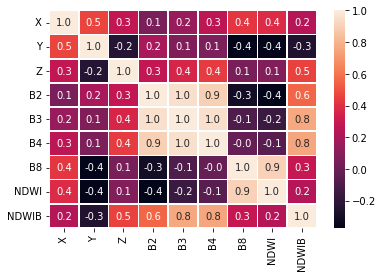

In [ ]:
import pandas as pd
import seaborn as sn
data = pd.read_excel("MarksData.xlsx")

print(data)
correlation = data.corr()

plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

In [ ]:
X = data.drop(columns=['X', 'Y', 'B2','B3','B4', 'B8','Z','NDWI'])
print(X)
y = data.drop(columns=['X', 'Y', 'B2','B3','B4', 'B8','NDWI','NDWIB'])
print(y)

          NDWIB
0     -0.192513
1     -0.192513
2     -0.192513
3     -0.192513
4     -0.192513
...         ...
32145 -0.092751
32146 -0.092751
32147 -0.092751
32148 -0.092751
32149 -0.092751

[32150 rows x 1 columns]
           Z
0      16.82
1      16.79
2      16.77
3      16.76
4      16.77
...      ...
32145  14.94
32146  14.94
32147  14.93
32148  14.95
32149  14.94

[32150 rows x 1 columns]


In [18]:
import pandas as pd
import sklearn.model_selection as ms
import sklearn.linear_model as lm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def fSimpleRegress(dataframe):
  X = dataframe.drop(columns=['B1','B10', 'B5', 'B8','B6','B7','B8','B8A','B9','X', 'Y','Z','B11','B12','B2','B3','B4'])
  print(X)
  y = dataframe.drop(columns=['B7', 'B8', 'B2','B3','B4', 'B8','B9','B1','B5','B6','B10', 'B11', 'B12', 'B8A', 'X', 'Y','NDWI'])
  print(y)
  X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 1/5, random_state = 0)

  regressor = lm.LinearRegression()
  regressor.fit(X_train, y_train)


  y_pred = np.array(regressor.predict(X_test))
  y_test = np.array(y_test)
  print('Mean_sqrd_error is ==', mean_squared_error (y_test, y_pred))
  RMSE = np.sqrt(mean_squared_error (y_test, y_pred))
  print('Root_mean_squared error of is ==', np.sqrt(mean_squared_error (y_test, y_pred)))
  print(regressor.coef_)
  print(regressor.intercept_)
  score = r2_score (y_test, y_pred)
  print('R2 socre é', score)
  np.set_printoptions(precision=2)
  result = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)

  X_test = X_test.reset_index(drop=True)
  y_compare = pd.DataFrame(result)
  y_compare = y_compare.rename(index=str, columns={0:'y_pred', 1:'y_test'})
  y_compare = y_compare.reset_index(drop=True)

  resultado_final = pd.concat([y_compare, X_test], axis=1)
  print(resultado_final)
  return RMSE
fSimpleRegress(data)

           NDWI
0     -0.091564
1     -0.091564
2     -0.100052
3     -0.100052
4     -0.100052
...         ...
13505 -0.100052
13506 -0.098182
13507 -0.123429
13508 -0.143898
13509 -0.103784

[13510 rows x 1 columns]
          Z
0      2.00
1      2.00
2      2.00
3      2.00
4      2.00
...     ...
13505  1.97
13506  1.97
13507  1.97
13508  7.88
13509  7.88

[13510 rows x 1 columns]
Mean_sqrd_error is == 19.03512638481382
Root_mean_squared error of is == 4.362926355648674
[[-164.06]]
[-10.99]
R2 socre é 0.5320859117010575
         y_pred  y_test      NDWI
0      7.768612   10.24 -0.114350
1     11.322201   13.65 -0.136010
2      4.080342    2.63 -0.091869
3      9.541091   13.81 -0.125153
4      7.446907    3.54 -0.112389
...         ...     ...       ...
2697  10.174269   24.57 -0.129013
2698   2.149590    2.96 -0.080101
2699   7.099981    1.08 -0.110274
2700  15.166082   14.38 -0.159439
2701   4.579821    4.29 -0.094913

[2702 rows x 3 columns]


4.362926355648674